In [1]:
from vllm import LLM, SamplingParams
import time

In [2]:
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
max_tokens = 10
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)

## bp16

In [3]:
model = "/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct"

llm = LLM(model=model, gpu_memory_utilization=0.9)

INFO 03-15 02:32:09 __init__.py:207] Automatically detected platform cuda.
INFO 03-15 02:32:17 config.py:549] This model supports multiple tasks: {'classify', 'embed', 'score', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 03-15 02:32:17 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=Observab

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 03-15 02:33:15 model_runner.py:1115] Loading model weights took 14.2487 GB
INFO 03-15 02:33:19 worker.py:267] Memory profiling takes 3.30 seconds
INFO 03-15 02:33:19 worker.py:267] the current vLLM instance can use total_gpu_memory (23.64GiB) x gpu_memory_utilization (0.90) = 21.28GiB
INFO 03-15 02:33:19 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 4.35GiB; the rest of the memory reserved for KV Cache is 2.60GiB.
INFO 03-15 02:33:19 executor_base.py:111] # cuda blocks: 3044, # CPU blocks: 4681
INFO 03-15 02:33:19 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 1.49x
INFO 03-15 02:33:22 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_ut

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s]

INFO 03-15 02:33:40 model_runner.py:1562] Graph capturing finished in 18 secs, took 0.21 GiB
INFO 03-15 02:33:40 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 24.51 seconds


In [4]:
# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2 ** p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, est. speed input: 24.71 toks/s, output: 49.41 toks/s]


duration: 0.20726847648620605
throughput: 48.2466034851446 tokens/s
avg latency: 0.020726847648620605

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s, est. speed input: 60.58 toks/s, output: 100.95 toks/s]


duration: 0.20068740844726562
throughput: 99.657473055941 tokens/s
avg latency: 0.02006874084472656

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 20.31it/s, est. speed input: 111.73 toks/s, output: 203.14 toks/s]


duration: 0.19990801811218262
throughput: 200.09202421062048 tokens/s
avg latency: 0.01999080181121826

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 39.11it/s, est. speed input: 215.20 toks/s, output: 391.26 toks/s]


duration: 0.20887327194213867
throughput: 383.0073577923427 tokens/s
avg latency: 0.020887327194213868

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 75.81it/s, est. speed input: 417.10 toks/s, output: 758.35 toks/s]


duration: 0.21564054489135742
throughput: 741.9754948245476 tokens/s
avg latency: 0.02156405448913574

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 133.28it/s, est. speed input: 733.26 toks/s, output: 1333.16 toks/s]


duration: 0.24711990356445312
throughput: 1294.9179543384635 tokens/s
avg latency: 0.024711990356445314

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 219.52it/s, est. speed input: 1207.70 toks/s, output: 2195.76 toks/s]


duration: 0.3028841018676758
throughput: 2113.0194554734458 tokens/s
avg latency: 0.03028841018676758

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 306.66it/s, est. speed input: 1686.94 toks/s, output: 3067.10 toks/s]

duration: 0.4385342597961426
throughput: 2918.8141437228232 tokens/s
avg latency: 0.04385342597961426



In [5]:
# save observations and restart kernel
# save as json
import json

data = {
    "durations": durations,
    "throughputs": throughputs,
    "latencies": latencies,
    "batch_sizes": batch_sizes,
    "prompts": prompts,
    "max_tokens": max_tokens

}

with open("basic_fp16_inference_observation.json", "w") as f:
    json.dump(data, f)



In [1]:
import json

# Read the data from the JSON file
with open("basic_fp16_inference_observation.json", "r") as f:
    data = json.load(f)

# Restore the lists
durations = data["durations"]
throughputs = data["throughputs"]
latencies = data["latencies"]
batch_sizes = data["batch_sizes"]
prompts = data["prompts"]
max_tokens = data["max_tokens"]

## int8 kv cache

In [2]:
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
import time

In [3]:
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)

In [4]:
model = "/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct-GPTQ-Int8"

llm_with_kv_cache = LLM(model=model,
                        gpu_memory_utilization=0.9)

INFO 03-15 02:43:22 __init__.py:207] Automatically detected platform cuda.
INFO 03-15 02:43:30 config.py:549] This model supports multiple tasks: {'reward', 'classify', 'generate', 'score', 'embed'}. Defaulting to 'generate'.
INFO 03-15 02:43:31 gptq_marlin.py:143] The model is convertible to gptq_marlin during runtime. Using gptq_marlin kernel.
INFO 03-15 02:43:31 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct-GPTQ-Int8', speculative_config=None, tokenizer='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct-GPTQ-Int8', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=gptq_marlin, enforce_eage

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


INFO 03-15 02:43:47 model_runner.py:1115] Loading model weights took 8.2412 GB
INFO 03-15 02:43:52 worker.py:267] Memory profiling takes 3.84 seconds
INFO 03-15 02:43:52 worker.py:267] the current vLLM instance can use total_gpu_memory (23.64GiB) x gpu_memory_utilization (0.90) = 21.28GiB
INFO 03-15 02:43:52 worker.py:267] model weights take 8.24GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 5.51GiB; the rest of the memory reserved for KV Cache is 7.45GiB.
INFO 03-15 02:43:52 executor_base.py:111] # cuda blocks: 8714, # CPU blocks: 4681
INFO 03-15 02:43:52 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 4.25x
INFO 03-15 02:43:55 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_util

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]

INFO 03-15 02:44:14 model_runner.py:1562] Graph capturing finished in 19 secs, took 0.27 GiB
INFO 03-15 02:44:14 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 26.31 seconds


In [5]:
# observations
durations_with_kv_cache = []
throughputs_with_kv_cache = []
latencies_with_kv_cache = []

for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm_with_kv_cache.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations_with_kv_cache.append(duration_s)
    throughputs_with_kv_cache.append(throughput)
    latencies_with_kv_cache.append(avg_latency)

bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s, est. speed input: 28.14 toks/s, output: 56.27 toks/s]


duration: 0.18344354629516602
throughput: 54.512683612808644 tokens/s
avg latency: 0.018344354629516602

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 13.93it/s, est. speed input: 83.61 toks/s, output: 139.34 toks/s]


duration: 0.14655303955078125
throughput: 136.46936331927742 tokens/s
avg latency: 0.014655303955078126

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 31.84it/s, est. speed input: 175.21 toks/s, output: 318.54 toks/s]


duration: 0.12869691848754883
throughput: 310.80775258709804 tokens/s
avg latency: 0.012869691848754883

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 61.55it/s, est. speed input: 338.80 toks/s, output: 615.96 toks/s]


duration: 0.133500337600708
throughput: 599.2494209211328 tokens/s
avg latency: 0.0133500337600708

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 113.28it/s, est. speed input: 623.34 toks/s, output: 1133.29 toks/s]


duration: 0.1458301544189453
throughput: 1097.1667734805185 tokens/s
avg latency: 0.014583015441894531

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 194.43it/s, est. speed input: 1069.88 toks/s, output: 1945.15 toks/s]


duration: 0.1713111400604248
throughput: 1867.94624031531 tokens/s
avg latency: 0.017131114006042482

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 281.01it/s, est. speed input: 1546.07 toks/s, output: 2810.94 toks/s]


duration: 0.23873066902160645
throughput: 2680.845333458503 tokens/s
avg latency: 0.023873066902160643

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 332.62it/s, est. speed input: 1829.79 toks/s, output: 3326.83 toks/s]

duration: 0.4046313762664795
throughput: 3163.3730725741493 tokens/s
avg latency: 0.04046313762664795



In [6]:
def render_plot(x, y1, y2, y3, y4, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line (FP32 throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color, label='FP16 Throughput', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)

    # plot the third line (kv cache throughput)
    ax1.plot(x, y3, color=color, label='kv cache Throughput', linestyle='--')

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color, label='FP16 Latency', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)

    # plot the fourth line (kv cache latency)
    ax2.plot(x, y4, color=color, label='kv cache Latency', linestyle='--')

    # Add legends
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

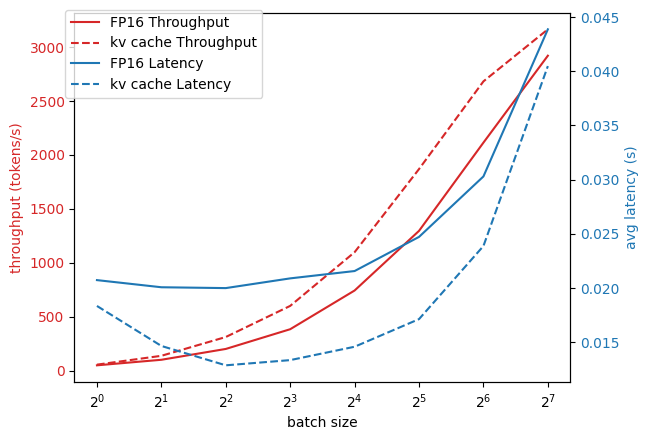

In [7]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    throughputs_with_kv_cache,
    latencies_with_kv_cache,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)